## Plot animation of temperature and vertical motion animation

### import package

In [1]:
import sys;
import h5py;
import numpy as np;
from matplotlib import pyplot as plt;
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter;

sys.path.append("/home/b11209013/Package/")
import Plot_Style as ps;

### Functions

In [2]:
def outer_time_einsum(A, B, out=None, dtype=None):
    """
    A: (x, t), B: (z,)
    Returns C: (x, z, t) with C[x,z,t] = A[x,t] * B[z]
    """
    if dtype is None:
        dtype = np.result_type(A, B)
    x, t = A.shape
    z    = B.size
    if out is None:
        out = np.empty((x, z, t), dtype=dtype, order='C')

    A_ = np.ascontiguousarray(A, dtype=dtype)   # contiguous, right dtype
    B_ = np.ascontiguousarray(B, dtype=dtype).squeeze()
    
    # einsum writes directly into `out`
    np.einsum('xt,z->xzt', A_, B_, out=out, optimize=True)
    return out

### Import files

In [3]:
fpath = "/home/b11209013/2025_Research/MSI/File/"; # file path

# load inverse matrix
with h5py.File(fpath+"inv_mat.h5","r") as f:
    inv_mat = np.array(f["inverse matrix"][:]); # shape: (x, k)
    k       = np.array(f["wavenumber"][:]);     # shape: (k,)
    x       = np.array(f["x"][:]);              # shape: (x,)

# load vertical mode
with h5py.File(fpath+"vertical_mode.h5","r") as f:
    G1      = np.array(f["G1"][:]); # shape: (1, z)
    G2      = np.array(f["G2"][:]); # shape: (1, z)
    z       = np.array(f["z"][:]);  # shape: (z,)

# load background field
with h5py.File(fpath+"bg_field.h5","r") as f:
    ρ0      = np.array(f["ρ0"][:]); # shape: (z,)
    
# load state vector
with h5py.File(fpath+"state.h5","r") as f:
    state   = np.array(f["state vector"][:]); # shape: (k, v, t)
    t       = np.array(f["time"][:]);         # shape: (t,)
    var     = np.array(f["variables"][:]);    # shape: (v,1)

### Reconstruct specific wave length

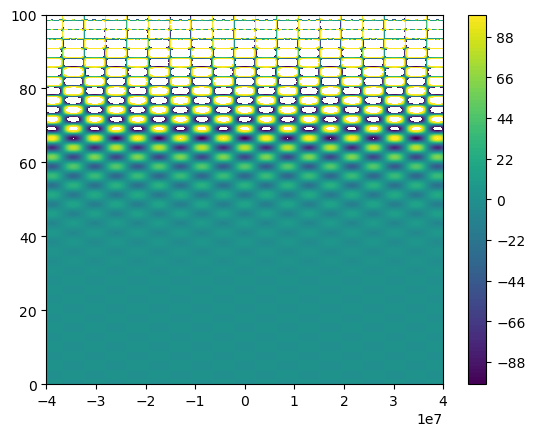

In [ ]:
# target λ (units: km)
λ    = 8640;
kn   = 2*np.pi*4320/λ;          # corresponding non-dimensional wavenumber 
kidx = np.argmin(np.abs(k-kn)); # index for specific λ

# limit domain of plotting
lft_bnd = np.argmin(np.abs(x+4320000));
rgt_bnd = np.argmin(np.abs(x-4320000));

# reconstruct physical temperature and vertical motion 
# w_pc = np.einsum("vt,x->vxt", state[kidx,:2,:] , inv_mat[:,kidx], optimize=True)[:,lft_bnd:rgt_bnd+1,:].real;
t1_pc = (state[kidx,3,:][:,None]@inv_mat[:,kidx][None,:]).real;
t2_pc = (state[kidx,4,:][:,None]@inv_mat[:,kidx][None,:]).real;


plt.contourf(x, t,t1_pc, levels=np.linspace(-100,100,101))
plt.colorbar()
plt.show()
# construct vertical profile
# w1 = outer_time_einsum(w_pc[0], G1) / ρ0[None,:,None];
# w2 = outer_time_einsum(w_pc[1], G2) / ρ0[None,:,None];

Temp_prof = np.empty((len(t),len(z),len(x)));

for i in range(len(t)):
    t1_prof = G1.T @ t1_pc[i][None,:]*(-0.0065+9.81/1004.5);
    t2_prof = G2.T @ t2_pc[i][None,:]*(-0.0065+9.81/1004.5);
    
    Temp_prof[i,...] = (t1_prof+t2_prof)/ρ0[:,None];    

### Plot the animation

In [5]:
from matplotlib.colors import Normalize

# assume Temp_prof has shape (nt, nz, nx)
temp32 = np.asarray(Temp_prof, dtype=np.float32, order="C")  # cheap to move around

vmin = np.nanmin(temp32); vmax = np.nanmax(temp32)
norm = Normalize(vmin=vmin, vmax=vmax)

tmax = np.max(t);

for i in range(len(t)):
    fig, ax = plt.subplots(figsize=(16, 9))

    # extent maps array indices to your physical coords
    extent = [x[lft_bnd], x[rgt_bnd], z[0], z[-1]]
    im = ax.imshow(temp32[i], origin="lower", extent=extent, norm=norm,
               cmap="RdBu_r", animated=True, aspect="auto")
    ax.set_xlim(-4_000_000, 4_000_000)
    ax.set_ylim(0, 15_000)
    ax.set_xticks(np.linspace(-4_000_000, 4_000_000, 5), ["-40","-20","0","20","40"], fontsize=20)
    ax.set_yticks(np.linspace(2_000, 14_000, 7), ["2","4","6","8","10","12","14"], fontsize=20)
    ax.set_xlabel("X [ 100 km ]", fontsize=24)
    ax.set_ylabel("Z [ km ]", fontsize=24)
    ax.set_title(r"$T^\prime$ ($\lambda$=8640km) "+f"{t[i]}/{tmax}", fontsize=32)

    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label("T [K]")

    plt.savefig(f"/data92/b11209013/MSI/Figure/Full/t={t[i]}.png",dpi=100)
    plt.close(fig)